In [173]:
%pip install seaborn matplotlib pandas scikit-learn xgboost catboost umap-learn lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from pathlib import Path
from typing import Tuple
import time
import json

def load_and_merge_data(sentence_path: str, target_path: str) -> pd.DataFrame:
    """
    Load sentence data and targets, merge on STRUCTURE_ID.
    Returns merged dataframe with only rows that have targets.
    """
    print("="*80)
    print("LOADING AND MERGING DATA")
    print("="*80)
    
    # Load sentence data
    print(f"\n📖 Loading sentences from: {sentence_path}")
    df_sentences = pd.read_csv(sentence_path)
    print(f"   Loaded {len(df_sentences):,} sentences")
    print(f"   Columns: {list(df_sentences.columns)}")
    
    # Load targets
    print(f"\n📖 Loading targets from: {target_path}")
    df_targets = pd.read_csv(target_path)
    print(f"   Loaded {len(df_targets):,} targets")
    print(f"   Columns: {list(df_targets.columns)}")
    
    # Merge on STRUCTURE_ID (inner join to keep only targets)
    print(f"\n🔗 Merging on STRUCTURE_ID...")
    df_merged = pd.merge(
        df_sentences, 
        df_targets, 
        on='STRUCTURE_ID', 
        how='inner'
    )
    
    print(f"   ✅ Merged dataset: {len(df_merged):,} rows")
    print(f"   Columns: {list(df_merged.columns)}")
    
    return df_merged

def embed_texts(texts: pd.Series, model_name: str = 'all-MiniLM-L6-v2') -> Tuple[np.ndarray, SentenceTransformer]:
    """
    Embed texts using sentence-transformers model.
    
    RECOMMENDED for list-like/structured text (less collapse):
    - 'paraphrase-MiniLM-L6-v2': Best for attribute lists, 384 dims, fast
    - 'multi-qa-MiniLM-L6-cos-v1': Semantic search optimized, 384 dims
    - 'all-MiniLM-L12-v2': Better at distinguishing similar texts, 384 dims
    - 'msmarco-MiniLM-L6-v3': Good for passage retrieval, 384 dims
    
    For technical content:
    - 'all-distilroberta-v1': RoBERTa-based, 768 dims, handles engineering terms
    - 'sentence-t5-base': T5-based for scientific text, 768 dims
    
    General models (may collapse on list-like text):
    - 'all-MiniLM-L6-v2': Fast, 384 dims, general text (CURRENT)
    - 'all-mpnet-base-v2': Higher quality, 768 dims, but may collapse
    
    Returns: (embeddings_array, model)
    """
    print("\n" + "="*80)
    print(f"EMBEDDING TEXTS WITH {model_name}")
    print("="*80)
    
    # Load model
    print(f"\n🤖 Loading model: {model_name}...")
    model = SentenceTransformer(model_name)
    print(f"   ✅ Model loaded")
    print(f"   Embedding dimension: {model.get_sentence_embedding_dimension()}")
    
    # Convert to list
    text_list = texts.tolist()
    
    # Embed with progress
    print(f"\n🔄 Embedding {len(text_list):,} texts...")
    start_time = time.time()
    
    embeddings = model.encode(
        text_list,
        show_progress_bar=True,
        batch_size=32,
        convert_to_numpy=True
    )
    
    elapsed = time.time() - start_time
    print(f"   ✅ Embedding complete in {elapsed:.1f}s")
    print(f"   Embeddings shape: {embeddings.shape}")
    print(f"   Speed: {len(text_list)/elapsed:.1f} texts/second")
    
    return embeddings, model

def save_with_embeddings(df_merged: pd.DataFrame, embeddings: np.ndarray, output_path: str):
    """
    Save merged data with embeddings as a new column.
    Embeddings are stored as JSON strings for each row.
    """
    print("\n" + "="*80)
    print("SAVING OUTPUT WITH EMBEDDINGS")
    print("="*80)
    
    # Create a copy to avoid modifying original
    df_output = df_merged.copy()
    
    # Convert embeddings to list of lists and then to JSON strings
    print(f"\n📦 Adding embeddings column...")
    df_output['EMBEDDING'] = [json.dumps(emb.tolist()) for emb in embeddings]
    
    # Save to CSV
    output_path = Path(output_path)
    output_path.parent.mkdir(exist_ok=True, parents=True)
    
    print(f"\n💾 Saving to: {output_path}")
    df_output.to_csv(output_path, index=False)
    
    print(f"   ✅ Saved {len(df_output):,} rows")
    print(f"   ✅ Embedding dimension: {embeddings.shape[1]}")
    print(f"   ✅ Columns: {list(df_output.columns)}")
    
    print(f"\n{'='*80}")
    print("COMPLETE")
    print(f"{'='*80}")
    
    return df_output

def create_embeddings_pipeline(
    sentence_path: str,
    target_path: str,
    output_path: str,
    model_name: str = 'all-MiniLM-L6-v2',
    text_column: str = 'PARAGRAPH'
) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Complete pipeline: load, merge, embed, save.
    
    Args:
        sentence_path: Path to CSV with STRUCTURE_ID and text
        target_path: Path to CSV with STRUCTURE_ID and targets
        output_path: Path to save output CSV with embeddings
        model_name: Sentence transformer model name
        text_column: Name of column containing text to embed
    
    Returns:
        (merged_dataframe_with_embeddings, embeddings_array)
    """
    # Load and merge
    df_merged = load_and_merge_data(sentence_path, target_path)
    
    # Check text column exists
    if text_column not in df_merged.columns:
        raise ValueError(f"Text column '{text_column}' not found in merged data. Available: {list(df_merged.columns)}")
    
    # Embed
    embeddings, model = embed_texts(df_merged[text_column], model_name=model_name)
    
    # Save with embeddings
    df_output = save_with_embeddings(df_merged, embeddings, output_path)
    
    return df_output, embeddings

c:\Users\wongb\Bridge-ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run the embedding pipeline
df_output, embeddings = create_embeddings_pipeline(
    sentence_path=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\sentence_data\sentences_short.csv",
    target_path=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\ml\targets.csv",
    output_path=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\embedding_work\merged_with_embeddings.csv",
    model_name='multi-qa-MiniLM-L6-cos-v1',  # Fast model, 384 dimensions
    text_column='PARAGRAPH'
)

print(f"\n✅ Pipeline complete!")
print(f"   Output data shape: {df_output.shape}")
print(f"   Embeddings shape: {embeddings.shape}")

LOADING AND MERGING DATA

📖 Loading sentences from: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\sentence_data\sentences_short.csv
   Loaded 4,914 sentences
   Columns: ['STRUCTURE_ID', 'COORDINATES', 'PARAGRAPH']

📖 Loading targets from: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\ml\targets.csv
   Loaded 487 targets
   Columns: ['Unnamed: 0', 'DATABASE_REF', 'STRUCTURE_ID', 'OBJECT_INTERSECTED', 'SUPPORT_TYPE', 'COLUMNS_PILES_PER_BENT', 'B_LONG_IN', 'B_TRANS_IN', 'CLEAR_HEIGHT_FT', 'LRR', 'SPACING_PITCH_IN', 'TRR', 'COLUMNS_PILES_0_1', 'L_H_LONG', 'L_H_TRANS', 'L_H_MIN', 'Z_KNOWN', 'CD_MIN', 'SCCI', 'CRITICAL_TRUTH_0_1']

🔗 Merging on STRUCTURE_ID...
   ✅ Merged dataset: 478 rows
   Columns: ['STRUCTURE_ID', 'COORDINATES', 'PARAGRAPH', 'Unnamed: 0', 'DATABASE_REF', 'OBJECT_INTERSECTED', 'SUPPORT_TYPE', 'COLUMNS_PILES_PER_BENT', 'B_LONG_IN', 'B_TRANS_IN', 'CLEAR_HEIGHT_FT', 'LRR', 'SPACING_PITCH_IN', 'TRR', 'COLUMNS_PILES_0_1', 'L_H_LO

Batches: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


   ✅ Embedding complete in 16.5s
   Embeddings shape: (478, 384)
   Speed: 28.9 texts/second

SAVING OUTPUT WITH EMBEDDINGS

📦 Adding embeddings column...

💾 Saving to: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\embedding_work\merged_with_embeddings.csv
   ✅ Saved 478 rows
   ✅ Embedding dimension: 384
   ✅ Columns: ['STRUCTURE_ID', 'COORDINATES', 'PARAGRAPH', 'Unnamed: 0', 'DATABASE_REF', 'OBJECT_INTERSECTED', 'SUPPORT_TYPE', 'COLUMNS_PILES_PER_BENT', 'B_LONG_IN', 'B_TRANS_IN', 'CLEAR_HEIGHT_FT', 'LRR', 'SPACING_PITCH_IN', 'TRR', 'COLUMNS_PILES_0_1', 'L_H_LONG', 'L_H_TRANS', 'L_H_MIN', 'Z_KNOWN', 'CD_MIN', 'SCCI', 'CRITICAL_TRUTH_0_1', 'EMBEDDING']

COMPLETE

✅ Pipeline complete!
   Output data shape: (478, 23)
   Embeddings shape: (478, 384)


# Embedding Pipeline for Bridge Paragraphs

This notebook creates embeddings from bridge paragraph descriptions.

## Model Options:
- **all-MiniLM-L6-v2**: Fast (384 dims), good general model - CURRENT
- **all-mpnet-base-v2**: Higher quality (768 dims), better for technical terms
- **sentence-t5-base**: Specialized for scientific/technical text (768 dims)

## Pipeline Steps:
1. Load sentence data (STRUCTURE_ID, COORDINATES, PARAGRAPH)
2. Load target data (STRUCTURE_ID, target values)
3. Merge on STRUCTURE_ID (keeps only bridges with targets)
4. Embed paragraphs using sentence-transformers
5. Save merged data + embeddings as CSV and NPY files

The model handles engineering concepts like PGA, seismic terms, and bridge terminology.

In [3]:
# Build numerical feature vectors from schemas
def load_schema_csv_pairs(schema_folder: Path, data_folder: Path):
    """Load matching schema/CSV pairs."""
    pairs = []
    schema_files = sorted(schema_folder.glob("*_schema_master.json"))
    
    for schema_file in schema_files:
        csv_name = schema_file.stem.replace("_schema_master", "") + ".csv"
        csv_path = data_folder / csv_name
        
        if not csv_path.exists():
            print(f"⚠️  Warning: No matching CSV for {schema_file.name}")
            continue
        
        with open(schema_file, 'r', encoding='utf-8') as f:
            schema = json.load(f)
        
        df = pd.read_csv(csv_path)
        source_name = csv_name.replace(".csv", "")
        pairs.append((schema, df, source_name))
        print(f"✅ Loaded: {schema_file.name} + {csv_name}")
    
    return pairs

def extract_numerical_value(value, field_type: str, code_map: dict):
    """
    Extract numerical value according to rules.
    Returns None if value should be skipped.
    """
    # Skip if value is missing
    if pd.isna(value):
        return None
    
    if field_type == 'numerical':
        # Use value as-is
        try:
            return float(value)
        except (ValueError, TypeError):
            return None
    
    elif field_type == 'numerical_coded':
        # Check if value is in code_map (coded value)
        if code_map:
            # Check both string and numeric representations
            if str(value) in code_map:
                return None  # Skip coded values
            if isinstance(value, (int, float)) and str(int(value)) in code_map:
                return None  # Skip coded values
        
        # Not a coded value, use it
        try:
            return float(value)
        except (ValueError, TypeError):
            return None
    
    return None

def build_numerical_vectors(schema_folder: str, data_folder: str):
    """
    Build numerical feature vectors for all bridges.
    Returns: (feature_matrix, feature_names, structure_ids)
    """
    print("="*80)
    print("BUILDING NUMERICAL FEATURE VECTORS")
    print("="*80)
    
    schema_folder = Path(schema_folder)
    data_folder = Path(data_folder)
    
    # Load all schema/CSV pairs
    print("\n📖 Loading schemas and data...")
    pairs = load_schema_csv_pairs(schema_folder, data_folder)
    
    if not pairs:
        raise ValueError("No valid schema/CSV pairs found")
    
    # Get structure IDs from first CSV
    first_df = pairs[0][1]
    structure_ids = first_df['STRUCTURE_ID'].values
    num_bridges = len(structure_ids)
    
    print(f"\n📊 Found {num_bridges:,} bridges")
    
    # Collect all numerical features
    all_features = []
    feature_names = []
    
    for schema, df, source_name in pairs:
        print(f"\n{'─'*60}")
        print(f"Processing: {source_name}")
        print(f"{'─'*60}")
        
        source_features_count = 0
        
        for column_name, schema_field in schema.items():
            if column_name in ['STRUCTURE_ID', 'COORDINATES']:
                continue
            
            field_type = schema_field.get('type')
            
            # Only process numerical and numerical_coded types
            if field_type not in ['numerical', 'numerical_coded']:
                continue
            
            if column_name not in df.columns:
                print(f"  ⚠️  Column '{column_name}' not in dataframe")
                continue
            
            # Extract values
            code_map = schema_field.get('code_map', {})
            values = []
            
            for value in df[column_name]:
                num_val = extract_numerical_value(value, field_type, code_map)
                values.append(num_val)
            
            # Check if we got any non-null values
            non_null_count = sum(1 for v in values if v is not None)
            if non_null_count == 0:
                print(f"  ⊘ SKIP: {column_name} (all values null/coded)")
                continue
            
            all_features.append(values)
            feature_names.append(f"{source_name}_{column_name}")
            source_features_count += 1
            print(f"  ✓ ADDED: {column_name} ({field_type}, {non_null_count}/{len(values)} valid)")
        
        print(f"\n  Subtotal: {source_features_count} features from {source_name}")
    
    # Convert to numpy array (transpose so rows are bridges, columns are features)
    feature_matrix = np.array(all_features).T
    
    print(f"\n{'='*60}")
    print(f"SUMMARY")
    print(f"{'='*60}")
    print(f"✅ Built numerical feature matrix")
    print(f"   Shape: {feature_matrix.shape}")
    print(f"   Bridges: {feature_matrix.shape[0]:,}")
    print(f"   Features: {feature_matrix.shape[1]}")
    print(f"   Total values: {feature_matrix.size:,}")
    print(f"   Non-null values: {np.sum(~np.isnan(feature_matrix.astype(float))):,}")
    
    return feature_matrix, feature_names, structure_ids

# Build numerical vectors
numerical_features, feature_names, structure_ids = build_numerical_vectors(
    schema_folder=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\schema_for_short",
    data_folder=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\enriched_data_fixed"
)

print(f"\n📋 Feature names ({len(feature_names)}):")
for i, name in enumerate(feature_names[:10]):
    print(f"   {i+1}. {name}")
if len(feature_names) > 10:
    print(f"   ... and {len(feature_names) - 10} more")

BUILDING NUMERICAL FEATURE VECTORS

📖 Loading schemas and data...
✅ Loaded: design_maps_schema_master.json + design_maps.csv
✅ Loaded: macrostrat_schema_master.json + macrostrat.csv
✅ Loaded: nbi_nominal_schema_master.json + nbi_nominal.csv
✅ Loaded: nbi_numerical_coded_schema_master.json + nbi_numerical_coded.csv
✅ Loaded: nbi_numerical_schema_master.json + nbi_numerical.csv
✅ Loaded: nfhl_fema_flood_schema_master.json + nfhl_fema_flood.csv
✅ Loaded: nshm_hazard_grid_schema_master.json + nshm_hazard_grid.csv

📊 Found 4,914 bridges

────────────────────────────────────────────────────────────
Processing: design_maps
────────────────────────────────────────────────────────────
  ✓ ADDED: PGA (numerical, 4914/4914 valid)
  ✓ ADDED: S1 (numerical, 4914/4914 valid)
  ✓ ADDED: SDS (numerical, 4914/4914 valid)
  ✓ ADDED: FPGA (numerical, 4914/4914 valid)

  Subtotal: 4 features from design_maps

────────────────────────────────────────────────────────────
Processing: macrostrat
─────────────

In [4]:
# Add numerical vectors to merged_with_embeddings.csv
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def add_numerical_features_to_merged(
    merged_csv_path: str,
    numerical_features: np.ndarray,
    feature_names: list,
    structure_ids_numerical: np.ndarray
):
    """
    Add normalized numerical feature vector as a new column to the merged CSV.
    Handles NaN values with median imputation before normalization.
    """
    print("\n" + "="*80)
    print("ADDING NORMALIZED NUMERICAL FEATURES TO MERGED FILE")
    print("="*80)
    
    # Load merged CSV
    print(f"\n📖 Loading merged CSV...")
    df_merged = pd.read_csv(merged_csv_path)
    print(f"   Loaded {len(df_merged):,} rows")
    
    # Remove NUMERICAL_FEATURES column if it already exists
    if 'NUMERICAL_FEATURES' in df_merged.columns:
        print(f"   ⚠️  NUMERICAL_FEATURES column exists, will replace it")
        df_merged = df_merged.drop(columns=['NUMERICAL_FEATURES'])
    
    # Create mapping from STRUCTURE_ID to numerical features
    print(f"\n🔗 Creating STRUCTURE_ID to features mapping...")
    id_to_features = {}
    for sid, features in zip(structure_ids_numerical, numerical_features):
        id_to_features[sid] = features
    
    # Build numerical vectors for each row in merged file
    print(f"\n📦 Building numerical vectors for merged rows...")
    numerical_vectors = []
    missing_ids = []
    
    for idx, row in df_merged.iterrows():
        sid = row['STRUCTURE_ID']
        if sid in id_to_features:
            numerical_vectors.append(id_to_features[sid])
        else:
            # Missing structure ID - use NaN vector
            numerical_vectors.append(np.full(len(feature_names), np.nan))
            missing_ids.append(sid)
    
    if missing_ids:
        print(f"   ⚠️  {len(missing_ids)} structure IDs not found in numerical features")
    
    numerical_vectors = np.array(numerical_vectors, dtype=float)
    
    # Handle NaN values and normalize
    print(f"\n🔧 Handling NaN values and normalizing...")
    print(f"   Original shape: {numerical_vectors.shape}")
    print(f"   NaN count: {np.sum(np.isnan(numerical_vectors)):,} / {numerical_vectors.size:,}")
    
    # Impute NaN values with median (robust to outliers)
    imputer = SimpleImputer(strategy='median')
    numerical_vectors_imputed = imputer.fit_transform(numerical_vectors)
    print(f"   ✅ Imputed NaN values with median")
    
    # Normalize using StandardScaler (mean=0, std=1)
    scaler = StandardScaler()
    numerical_vectors_normalized = scaler.fit_transform(numerical_vectors_imputed)
    print(f"   ✅ Normalized features (StandardScaler)")
    print(f"   Normalized mean: {numerical_vectors_normalized.mean():.6f}")
    print(f"   Normalized std: {numerical_vectors_normalized.std():.6f}")
    
    # Add as JSON string column
    print(f"\n📦 Adding NUMERICAL_FEATURES column...")
    df_merged['NUMERICAL_FEATURES'] = [json.dumps(vec.tolist()) for vec in numerical_vectors_normalized]
    
    # Save updated CSV
    print(f"\n💾 Saving updated CSV to: {merged_csv_path}")
    df_merged.to_csv(merged_csv_path, index=False)
    
    print(f"   ✅ Saved {len(df_merged):,} rows")
    print(f"   ✅ Columns: {list(df_merged.columns)}")
    print(f"   ✅ Numerical features dimension: {len(feature_names)}")
    
    print(f"\n{'='*80}")
    print("COMPLETE")
    print(f"{'='*80}")
    
    return df_merged, numerical_vectors_normalized

# Add numerical features to merged file
df_updated, numerical_vectors_normalized = add_numerical_features_to_merged(
    merged_csv_path=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\embedding_work\merged_with_embeddings.csv",
    numerical_features=numerical_features,
    feature_names=feature_names,
    structure_ids_numerical=structure_ids
)

print(f"\n✅ Updated merged file now contains:")
print(f"   - {len(df_updated)} rows")
print(f"   - EMBEDDING column (384 dims)")
print(f"   - NUMERICAL_FEATURES column ({len(feature_names)} dims, normalized)")
print(f"\n📊 Normalized features stats:")
print(f"   Mean: {numerical_vectors_normalized.mean():.6f}")
print(f"   Std: {numerical_vectors_normalized.std():.6f}")
print(f"   Min: {numerical_vectors_normalized.min():.6f}")
print(f"   Max: {numerical_vectors_normalized.max():.6f}")


ADDING NORMALIZED NUMERICAL FEATURES TO MERGED FILE

📖 Loading merged CSV...
   Loaded 478 rows

🔗 Creating STRUCTURE_ID to features mapping...

📦 Building numerical vectors for merged rows...

🔧 Handling NaN values and normalizing...
   Original shape: (478, 34)
   NaN count: 2,681 / 16,252
   ✅ Imputed NaN values with median
   ✅ Normalized features (StandardScaler)
   Normalized mean: -0.000000
   Normalized std: 1.000000

📦 Adding NUMERICAL_FEATURES column...

💾 Saving updated CSV to: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\embedding_work\merged_with_embeddings.csv
   ✅ Saved 478 rows
   ✅ Columns: ['STRUCTURE_ID', 'COORDINATES', 'PARAGRAPH', 'Unnamed: 0', 'DATABASE_REF', 'OBJECT_INTERSECTED', 'SUPPORT_TYPE', 'COLUMNS_PILES_PER_BENT', 'B_LONG_IN', 'B_TRANS_IN', 'CLEAR_HEIGHT_FT', 'LRR', 'SPACING_PITCH_IN', 'TRR', 'COLUMNS_PILES_0_1', 'L_H_LONG', 'L_H_TRANS', 'L_H_MIN', 'Z_KNOWN', 'CD_MIN', 'SCCI', 'CRITICAL_TRUTH_0_1', 'EMBEDDING', 'NUMERICAL_F

LOADING EMBEDDINGS FROM CSV

✅ Loaded 478 rows
   Columns: ['STRUCTURE_ID', 'COORDINATES', 'PARAGRAPH', 'Unnamed: 0', 'DATABASE_REF', 'OBJECT_INTERSECTED', 'SUPPORT_TYPE', 'COLUMNS_PILES_PER_BENT', 'B_LONG_IN', 'B_TRANS_IN', 'CLEAR_HEIGHT_FT', 'LRR', 'SPACING_PITCH_IN', 'TRR', 'COLUMNS_PILES_0_1', 'L_H_LONG', 'L_H_TRANS', 'L_H_MIN', 'Z_KNOWN', 'CD_MIN', 'SCCI', 'CRITICAL_TRUTH_0_1', 'EMBEDDING', 'NUMERICAL_FEATURES']

📦 Parsing embeddings from JSON...
   ✅ Parsed embeddings shape: (478, 384)

EMBEDDING DIAGNOSTIC TESTS

📊 BASIC STATISTICS
   Shape: (478, 384)
   Mean: -0.001117
   Std: 0.051019
   Min: -0.170449
   Max: 0.165297

📊 PER-DIMENSION STATISTICS
   Mean of dimension means: -0.001117
   Mean of dimension stds: 0.010876
   Min dimension std: 0.000000
   Max dimension std: 0.017485

🔍 COSINE SIMILARITY ANALYSIS (sample of 1000 embeddings)
   Using all 478 embeddings

📊 SIMILARITY DISTRIBUTION
   Mean similarity: 0.952782
   Std similarity: 0.026321
   Min similarity: 0.768707
 

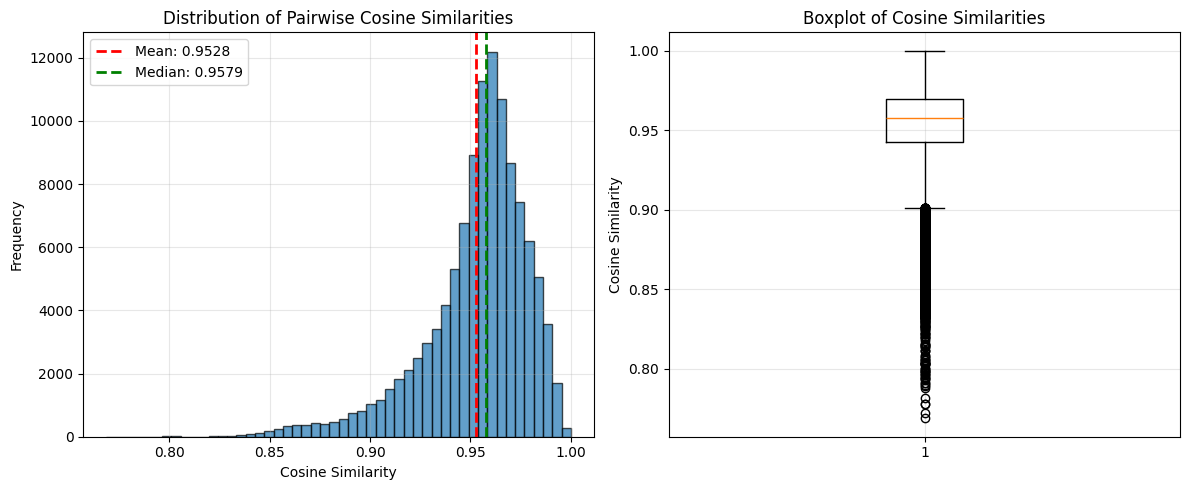

In [5]:
# Load and test embeddings
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def load_embeddings_from_csv(csv_path: str) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Load CSV and parse embeddings from JSON strings back to numpy array.
    """
    print("="*80)
    print("LOADING EMBEDDINGS FROM CSV")
    print("="*80)
    
    df = pd.read_csv(csv_path)
    print(f"\n✅ Loaded {len(df):,} rows")
    print(f"   Columns: {list(df.columns)}")
    
    # Parse embeddings from JSON strings
    print(f"\n📦 Parsing embeddings from JSON...")
    embeddings_list = [json.loads(emb) for emb in df['EMBEDDING']]
    embeddings = np.array(embeddings_list)
    
    print(f"   ✅ Parsed embeddings shape: {embeddings.shape}")
    
    return df, embeddings

def analyze_embeddings(embeddings: np.ndarray, sample_size: int = 1000):
    """
    Run diagnostic tests on embeddings to check for collapse and quality.
    """
    print("\n" + "="*80)
    print("EMBEDDING DIAGNOSTIC TESTS")
    print("="*80)
    
    # Basic statistics
    print(f"\n📊 BASIC STATISTICS")
    print(f"   Shape: {embeddings.shape}")
    print(f"   Mean: {embeddings.mean():.6f}")
    print(f"   Std: {embeddings.std():.6f}")
    print(f"   Min: {embeddings.min():.6f}")
    print(f"   Max: {embeddings.max():.6f}")
    
    # Per-dimension statistics
    print(f"\n📊 PER-DIMENSION STATISTICS")
    dim_means = embeddings.mean(axis=0)
    dim_stds = embeddings.std(axis=0)
    print(f"   Mean of dimension means: {dim_means.mean():.6f}")
    print(f"   Mean of dimension stds: {dim_stds.mean():.6f}")
    print(f"   Min dimension std: {dim_stds.min():.6f}")
    print(f"   Max dimension std: {dim_stds.max():.6f}")
    
    # Compute pairwise cosine similarities on sample
    print(f"\n🔍 COSINE SIMILARITY ANALYSIS (sample of {sample_size} embeddings)")
    
    # Sample for efficiency if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        sample_embeddings = embeddings[indices]
        print(f"   Sampled {sample_size} out of {len(embeddings):,} embeddings")
    else:
        sample_embeddings = embeddings
        print(f"   Using all {len(embeddings):,} embeddings")
    
    # Compute cosine similarity matrix
    cos_sim_matrix = cosine_similarity(sample_embeddings)
    
    # Get upper triangle (exclude diagonal)
    upper_triangle = np.triu(cos_sim_matrix, k=1)
    similarities = upper_triangle[upper_triangle != 0]
    
    print(f"\n📊 SIMILARITY DISTRIBUTION")
    print(f"   Mean similarity: {similarities.mean():.6f}")
    print(f"   Std similarity: {similarities.std():.6f}")
    print(f"   Min similarity: {similarities.min():.6f}")
    print(f"   Max similarity: {similarities.max():.6f}")
    print(f"   Median similarity: {np.median(similarities):.6f}")
    
    # Percentiles
    print(f"\n📊 SIMILARITY PERCENTILES")
    percentiles = [5, 25, 50, 75, 95]
    for p in percentiles:
        val = np.percentile(similarities, p)
        print(f"   {p}th percentile: {val:.6f}")
    
    # Collapse check
    print(f"\n⚠️  COLLAPSE CHECK")
    if similarities.mean() > 0.95:
        print(f"   ❌ SEVERE COLLAPSE: Mean similarity {similarities.mean():.4f} > 0.95")
    elif similarities.mean() > 0.90:
        print(f"   ⚠️  HIGH COLLAPSE: Mean similarity {similarities.mean():.4f} > 0.90")
    elif similarities.mean() > 0.80:
        print(f"   ⚠️  MODERATE COLLAPSE: Mean similarity {similarities.mean():.4f} > 0.80")
    else:
        print(f"   ✅ GOOD DIVERSITY: Mean similarity {similarities.mean():.4f} < 0.80")
    
    if similarities.std() < 0.05:
        print(f"   ⚠️  LOW VARIANCE: Std {similarities.std():.4f} < 0.05 (embeddings too similar)")
    else:
        print(f"   ✅ GOOD VARIANCE: Std {similarities.std():.4f} >= 0.05")
    
    # Plot histogram
    print(f"\n📊 Plotting similarity distribution...")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(similarities.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {similarities.mean():.4f}')
    plt.axvline(np.median(similarities), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities):.4f}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pairwise Cosine Similarities')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(similarities, vert=True)
    plt.ylabel('Cosine Similarity')
    plt.title('Boxplot of Cosine Similarities')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return cos_sim_matrix, similarities

# Load the embeddings
df, embeddings = load_embeddings_from_csv(
    r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\embedding_work\merged_with_embeddings.csv"
)

# Run diagnostic tests
cos_sim_matrix, similarities = analyze_embeddings(embeddings, sample_size=1000)

In [6]:
# Additional tests: Find most similar and most dissimilar pairs
def find_extreme_pairs(df: pd.DataFrame, cos_sim_matrix: np.ndarray, n_pairs: int = 5):
    """
    Find the most similar and most dissimilar pairs of bridges.
    """
    print("\n" + "="*80)
    print("EXTREME SIMILARITY PAIRS")
    print("="*80)
    
    # Get upper triangle indices (exclude diagonal)
    i_upper, j_upper = np.triu_indices_from(cos_sim_matrix, k=1)
    
    # Get all similarities with their indices
    similarities = cos_sim_matrix[i_upper, j_upper]
    
    # Most similar pairs
    print(f"\n🔝 TOP {n_pairs} MOST SIMILAR PAIRS:")
    print(f"{'─'*80}")
    most_similar_idx = np.argsort(similarities)[-n_pairs:][::-1]
    
    for rank, idx in enumerate(most_similar_idx, 1):
        i, j = i_upper[idx], j_upper[idx]
        sim = similarities[idx]
        
        print(f"\n#{rank} - Similarity: {sim:.6f}")
        print(f"   Bridge A: {df.iloc[i]['STRUCTURE_ID']}")
        print(f"   Bridge B: {df.iloc[j]['STRUCTURE_ID']}")
        print(f"   Text A: {df.iloc[i]['PARAGRAPH'][:150]}...")
        print(f"   Text B: {df.iloc[j]['PARAGRAPH'][:150]}...")
    
    # Most dissimilar pairs
    print(f"\n{'='*80}")
    print(f"⬇️  TOP {n_pairs} MOST DISSIMILAR PAIRS:")
    print(f"{'─'*80}")
    most_dissimilar_idx = np.argsort(similarities)[:n_pairs]
    
    for rank, idx in enumerate(most_dissimilar_idx, 1):
        i, j = i_upper[idx], j_upper[idx]
        sim = similarities[idx]
        
        print(f"\n#{rank} - Similarity: {sim:.6f}")
        print(f"   Bridge A: {df.iloc[i]['STRUCTURE_ID']}")
        print(f"   Bridge B: {df.iloc[j]['STRUCTURE_ID']}")
        print(f"   Text A: {df.iloc[i]['PARAGRAPH'][:150]}...")
        print(f"   Text B: {df.iloc[j]['PARAGRAPH'][:150]}...")

# Find extreme pairs
find_extreme_pairs(df, cos_sim_matrix, n_pairs=3)


EXTREME SIMILARITY PAIRS

🔝 TOP 3 MOST SIMILAR PAIRS:
────────────────────────────────────────────────────────────────────────────────

#1 - Similarity: 1.000000
   Bridge A: 0008085C
   Bridge B: 0008085D
   Text A: design_peak_ground_acceleration: high seismic demand. spectral_acceleration_1.0s: high seismic demand. design_spectral_acceleration: very high seismic...
   Text B: design_peak_ground_acceleration: high seismic demand. spectral_acceleration_1.0s: high seismic demand. design_spectral_acceleration: very high seismic...

#2 - Similarity: 1.000000
   Bridge A: 0007299A
   Bridge B: 0007299B
   Text A: design_peak_ground_acceleration: high seismic demand. spectral_acceleration_1.0s: high seismic demand. design_spectral_acceleration: very high seismic...
   Text B: design_peak_ground_acceleration: high seismic demand. spectral_acceleration_1.0s: high seismic demand. design_spectral_acceleration: very high seismic...

#3 - Similarity: 1.000000
   Bridge A: 0008175C
   Bridge B: 


EMBEDDING SPACE VISUALIZATION

   Using all 478 embeddings

🔍 Running PCA...
   Explained variance: 0.2904
   PC1: 0.1710
   PC2: 0.1194

🔍 Running t-SNE...
   ✅ t-SNE complete


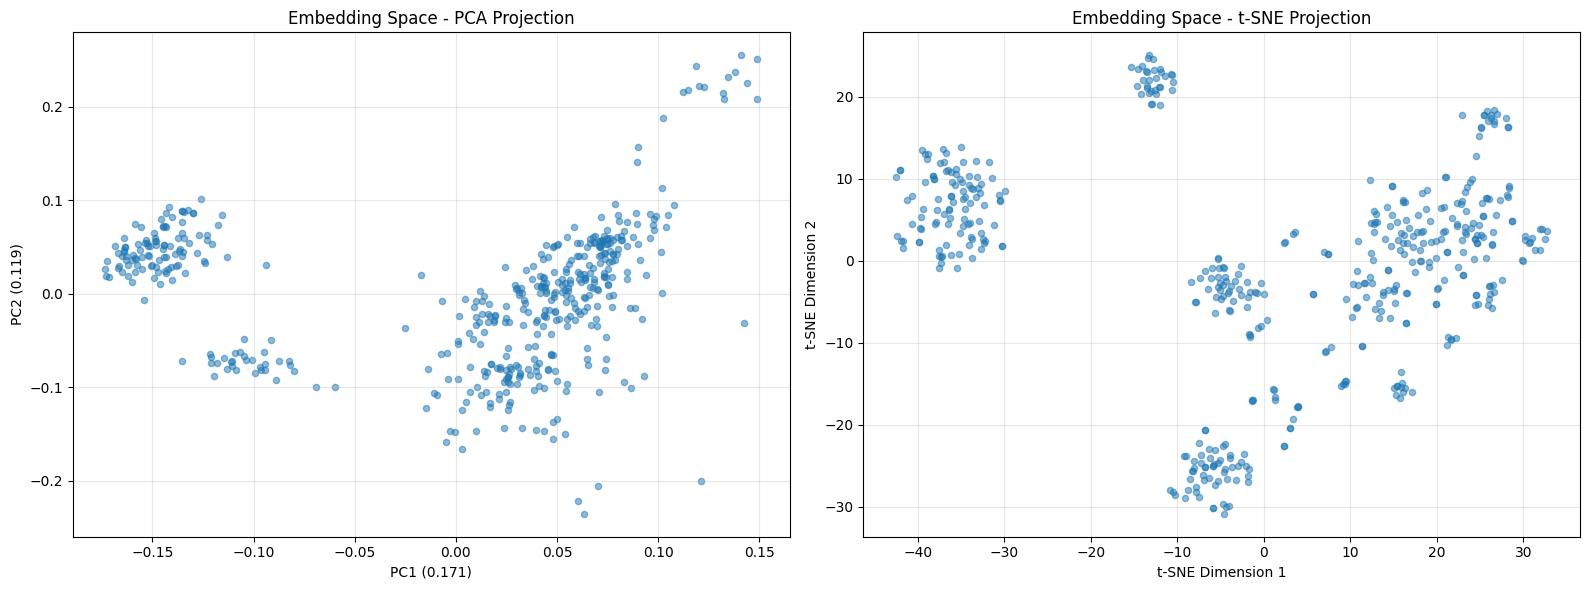


✅ PC1 explains 17.10% of variance - good diversity


In [7]:
# Visualize embedding space with dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embedding_space(embeddings: np.ndarray, sample_size: int = 1000):
    """
    Visualize embeddings in 2D using PCA and t-SNE.
    """
    print("\n" + "="*80)
    print("EMBEDDING SPACE VISUALIZATION")
    print("="*80)
    
    # Sample if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        sample_embeddings = embeddings[indices]
        print(f"\n   Sampled {sample_size} out of {len(embeddings):,} embeddings")
    else:
        sample_embeddings = embeddings
        print(f"\n   Using all {len(embeddings):,} embeddings")
    
    # PCA
    print(f"\n🔍 Running PCA...")
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(sample_embeddings)
    print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"   PC1: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"   PC2: {pca.explained_variance_ratio_[1]:.4f}")
    
    # t-SNE
    print(f"\n🔍 Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_tsne = tsne.fit_transform(sample_embeddings)
    print(f"   ✅ t-SNE complete")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # PCA plot
    axes[0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5, s=20)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    axes[0].set_title('Embedding Space - PCA Projection')
    axes[0].grid(True, alpha=0.3)
    
    # t-SNE plot
    axes[1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5, s=20)
    axes[1].set_xlabel('t-SNE Dimension 1')
    axes[1].set_ylabel('t-SNE Dimension 2')
    axes[1].set_title('Embedding Space - t-SNE Projection')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check for collapse in PCA
    if pca.explained_variance_ratio_[0] > 0.50:
        print(f"\n⚠️  WARNING: PC1 explains {pca.explained_variance_ratio_[0]:.2%} of variance")
        print(f"   This suggests embeddings may be collapsing to a low-dimensional subspace")
    else:
        print(f"\n✅ PC1 explains {pca.explained_variance_ratio_[0]:.2%} of variance - good diversity")
    
    return embeddings_pca, embeddings_tsne

# Visualize embedding space
embeddings_pca, embeddings_tsne = visualize_embedding_space(embeddings, sample_size=1000)

In [8]:
# Baseline ML Models with PCA
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not installed. Install with: pip install lightgbm")
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

def load_features_and_targets(csv_path: str, target_column: str = 'SCCI'):
    """
    Load and parse both embedding and numerical features from CSV.
    Removes rows where target is null.
    """
    print("="*80)
    print("LOADING FEATURES AND TARGETS")
    print("="*80)
    
    df = pd.read_csv(csv_path)
    print(f"\n✅ Loaded {len(df):,} rows")
    
    # Check for null targets and remove them
    print(f"\n🔍 Checking for null targets in '{target_column}'...")
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found. Available: {list(df.columns)}")
    
    null_count = df[target_column].isna().sum()
    if null_count > 0:
        print(f"   ⚠️  Found {null_count} null values in target column")
        df = df[df[target_column].notna()].copy()
        print(f"   ✅ Removed null rows, {len(df):,} rows remaining")
    else:
        print(f"   ✅ No null values found")
    
    # Parse embeddings
    print(f"\n📦 Parsing EMBEDDING features...")
    embeddings = np.array([json.loads(emb) for emb in df['EMBEDDING']])
    print(f"   Shape: {embeddings.shape}")
    
    # Parse numerical features
    print(f"\n📦 Parsing NUMERICAL_FEATURES...")
    numerical_features = np.array([json.loads(feat) for feat in df['NUMERICAL_FEATURES']])
    print(f"   Shape: {numerical_features.shape}")
    
    # Extract target
    print(f"\n🎯 Extracting target: {target_column}")
    targets = df[target_column].values
    print(f"   Shape: {targets.shape}")
    print(f"   Range: [{targets.min():.2f}, {targets.max():.2f}]")
    print(f"   Mean: {targets.mean():.2f}")
    print(f"   Std: {targets.std():.2f}")
    
    return embeddings, numerical_features, targets, df

def apply_pca(X, n_components=50, name="Features"):
    """
    Apply PCA to reduce dimensionality.
    """
    print(f"\n🔍 Applying PCA to {name}...")
    print(f"   Original dimensions: {X.shape[1]}")
    
    # Adjust n_components if larger than available
    n_components = min(n_components, X.shape[1], X.shape[0])
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    explained_var = pca.explained_variance_ratio_.sum()
    print(f"   PCA components: {n_components}")
    print(f"   Explained variance: {explained_var:.4f}")
    print(f"   New shape: {X_pca.shape}")
    
    return X_pca, pca

def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_name, n_folds=5, use_manual_cv=True):
    """
    Train Ridge, Lasso, RandomForest, XGBoost, CatBoost with 5-fold cross-validation.
    Hyperparameters optimized for small datasets (~370 samples).
    
    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training targets
        y_test: Test targets
        feature_name: Name of feature set (for display)
        n_folds: Number of CV folds (default: 5)
        use_manual_cv: If True, use manual CV for all models (ensures fairness). Default: True
    """
    print(f"\n{'='*80}")
    print(f"TRAINING MODELS: {feature_name} ({n_folds}-Fold CV)")
    print(f"{'='*80}")
    print(f"CV Method: {'Manual (all models)' if use_manual_cv else 'sklearn cross_validate + manual for CatBoost'}")
    
    models = {
        'Ridge': Ridge(alpha=10.0, random_state=42),
        'Lasso': Lasso(alpha=1.0, random_state=42, max_iter=5000),
        'RandomForest': RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=-1, 
            max_depth=5, min_samples_split=10, min_samples_leaf=5
        ),
        'ExtraTrees': ExtraTreesRegressor(
            n_estimators=50, random_state=42, n_jobs=-1,
            max_depth=5, min_samples_split=10, min_samples_leaf=5
        ),
        'HistGradientBoosting': HistGradientBoostingRegressor(
            max_iter=50, max_depth=4, learning_rate=0.05, 
            l2_regularization=3.0, random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=50, random_state=42, max_depth=3, 
            learning_rate=0.05, reg_alpha=1.0, reg_lambda=1.0
        ),
        'CatBoost': CatBoostRegressor(
            iterations=50, depth=4, learning_rate=0.05, l2_leaf_reg=3.0, 
            random_seed=42, verbose=False, allow_writing_files=False
        )
    }
    
    # Add LightGBM if available
    if LIGHTGBM_AVAILABLE:
        models['LightGBM'] = LGBMRegressor(
            n_estimators=50, random_state=42, max_depth=4,
            learning_rate=0.05, reg_alpha=1.0, reg_lambda=3.0,
            verbose=-1
        )
    
    # Setup K-Fold CV (same for all models)
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\n{'─'*60}")
        print(f"Training {model_name} with {n_folds}-Fold CV...")
        print(f"{'─'*60}")
        
        # Use manual CV for all models to ensure complete fairness
        if use_manual_cv or model_name == 'CatBoost':
            # Manual cross-validation (same implementation for all)
            train_r2_scores = []
            test_r2_scores = []
            train_rmse_scores = []
            test_rmse_scores = []
            train_mae_scores = []
            test_mae_scores = []
            
            for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                # Clone model for each fold
                if model_name == 'Ridge':
                    fold_model = Ridge(alpha=10.0, random_state=42)
                elif model_name == 'Lasso':
                    fold_model = Lasso(alpha=1.0, random_state=42, max_iter=5000)
                elif model_name == 'RandomForest':
                    fold_model = RandomForestRegressor(
                        n_estimators=50, random_state=42, n_jobs=-1, 
                        max_depth=5, min_samples_split=10, min_samples_leaf=5
                    )
                elif model_name == 'ExtraTrees':
                    fold_model = ExtraTreesRegressor(
                        n_estimators=50, random_state=42, n_jobs=-1,
                        max_depth=5, min_samples_split=10, min_samples_leaf=5
                    )
                elif model_name == 'HistGradientBoosting':
                    fold_model = HistGradientBoostingRegressor(
                        max_iter=50, max_depth=4, learning_rate=0.05, 
                        l2_regularization=3.0, random_state=42
                    )
                elif model_name == 'XGBoost':
                    fold_model = XGBRegressor(
                        n_estimators=50, random_state=42, max_depth=3, 
                        learning_rate=0.05, reg_alpha=1.0, reg_lambda=1.0
                    )
                elif model_name == 'LightGBM':
                    fold_model = LGBMRegressor(
                        n_estimators=50, random_state=42, max_depth=4,
                        learning_rate=0.05, reg_alpha=1.0, reg_lambda=3.0,
                        verbose=-1
                    )
                elif model_name == 'CatBoost':
                    fold_model = CatBoostRegressor(
                        iterations=50, depth=4, learning_rate=0.05, l2_leaf_reg=3.0, 
                        random_seed=42, verbose=False, allow_writing_files=False
                    )
                
                fold_model.fit(X_fold_train, y_fold_train)
                
                # Train predictions
                y_fold_train_pred = fold_model.predict(X_fold_train)
                train_r2_scores.append(r2_score(y_fold_train, y_fold_train_pred))
                train_rmse_scores.append(np.sqrt(mean_squared_error(y_fold_train, y_fold_train_pred)))
                train_mae_scores.append(mean_absolute_error(y_fold_train, y_fold_train_pred))
                
                # Validation predictions
                y_fold_val_pred = fold_model.predict(X_fold_val)
                test_r2_scores.append(r2_score(y_fold_val, y_fold_val_pred))
                test_rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_fold_val_pred)))
                test_mae_scores.append(mean_absolute_error(y_fold_val, y_fold_val_pred))
            
            # Calculate statistics
            cv_train_r2_mean = np.mean(train_r2_scores)
            cv_train_r2_std = np.std(train_r2_scores)
            cv_test_r2_mean = np.mean(test_r2_scores)
            cv_test_r2_std = np.std(test_r2_scores)
            
            cv_train_rmse_mean = np.mean(train_rmse_scores)
            cv_train_rmse_std = np.std(train_rmse_scores)
            cv_test_rmse_mean = np.mean(test_rmse_scores)
            cv_test_rmse_std = np.std(test_rmse_scores)
            
            cv_train_mae_mean = np.mean(train_mae_scores)
            cv_train_mae_std = np.std(train_mae_scores)
            cv_test_mae_mean = np.mean(test_mae_scores)
            cv_test_mae_std = np.std(test_mae_scores)
            
        else:
            # sklearn cross_validate (only if use_manual_cv=False)
            scoring = {
                'r2': 'r2',
                'neg_rmse': 'neg_root_mean_squared_error',
                'neg_mae': 'neg_mean_absolute_error'
            }
            
            cv_results = cross_validate(
                model, X_train, y_train, cv=kfold, scoring=scoring,
                return_train_score=True, n_jobs=-1
            )
            
            cv_train_r2_mean = cv_results['train_r2'].mean()
            cv_train_r2_std = cv_results['train_r2'].std()
            cv_test_r2_mean = cv_results['test_r2'].mean()
            cv_test_r2_std = cv_results['test_r2'].std()
            
            cv_train_rmse_mean = -cv_results['train_neg_rmse'].mean()
            cv_train_rmse_std = cv_results['train_neg_rmse'].std()
            cv_test_rmse_mean = -cv_results['test_neg_rmse'].mean()
            cv_test_rmse_std = cv_results['test_neg_rmse'].std()
            
            cv_train_mae_mean = -cv_results['train_neg_mae'].mean()
            cv_train_mae_std = cv_results['train_neg_mae'].std()
            cv_test_mae_mean = -cv_results['test_neg_mae'].mean()
            cv_test_mae_std = cv_results['test_neg_mae'].std()
        
        # Train final model on full training set
        model.fit(X_train, y_train)
        
        # Evaluate on held-out test set
        y_pred_test = model.predict(X_test)
        holdout_r2 = r2_score(y_test, y_pred_test)
        holdout_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        holdout_mae = mean_absolute_error(y_test, y_pred_test)
        
        results[model_name] = {
            'cv_train_r2_mean': cv_train_r2_mean,
            'cv_train_r2_std': cv_train_r2_std,
            'cv_test_r2_mean': cv_test_r2_mean,
            'cv_test_r2_std': cv_test_r2_std,
            'cv_train_rmse_mean': cv_train_rmse_mean,
            'cv_train_rmse_std': cv_train_rmse_std,
            'cv_test_rmse_mean': cv_test_rmse_mean,
            'cv_test_rmse_std': cv_test_rmse_std,
            'cv_train_mae_mean': cv_train_mae_mean,
            'cv_train_mae_std': cv_train_mae_std,
            'cv_test_mae_mean': cv_test_mae_mean,
            'cv_test_mae_std': cv_test_mae_std,
            'holdout_r2': holdout_r2,
            'holdout_rmse': holdout_rmse,
            'holdout_mae': holdout_mae
        }
        
        print(f"  CV Train R²: {cv_train_r2_mean:.4f} ± {cv_train_r2_std:.4f}")
        print(f"  CV Test R²:  {cv_test_r2_mean:.4f} ± {cv_test_r2_std:.4f}")
        print(f"  CV Train RMSE: {cv_train_rmse_mean:.4f} ± {cv_train_rmse_std:.4f}")
        print(f"  CV Test RMSE:  {cv_test_rmse_mean:.4f} ± {cv_test_rmse_std:.4f}")
        print(f"  ---")
        print(f"  Holdout Test R²:   {holdout_r2:.4f}")
        print(f"  Holdout Test RMSE: {holdout_rmse:.4f}")
        print(f"  Holdout Test MAE:  {holdout_mae:.4f}")
    
    return results

def optimize_pca_components(X, y, baseline=40, feature_name="Features", test_size=0.2, n_folds=5):
    """
    Automatically find the optimal number of PCA components using a coarse-to-fine search.
    
    Args:
        X: Feature matrix
        y: Target values
        baseline: Starting point for search (default: 40)
        feature_name: Name for logging
        test_size: Test set proportion
        n_folds: Number of CV folds
    
    Returns:
        optimal_n_components, all_results_dict
    """
    print(f"\n{'='*80}")
    print(f"OPTIMIZING PCA COMPONENTS FOR {feature_name}")
    print(f"{'='*80}")
    
    max_components = min(X.shape[0], X.shape[1]) - 1
    
    # Step 1: Coarse search around baseline
    print(f"\n🔍 STEP 1: Coarse search (step size = 10)")
    coarse_candidates = [baseline - 20, baseline - 10, baseline, baseline + 10, baseline + 20]
    coarse_candidates = [c for c in coarse_candidates if 5 <= c <= max_components]
    print(f"   Testing: {coarse_candidates}")
    
    coarse_results = {}
    for n_comp in coarse_candidates:
        X_pca, _ = apply_pca(X, n_comp, feature_name)
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=test_size, random_state=42)
        
        # Use Ridge for quick evaluation (fastest model)
        model = Ridge(alpha=10.0, random_state=42)
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
        mean_r2 = cv_results['test_score'].mean()
        std_r2 = cv_results['test_score'].std()
        
        coarse_results[n_comp] = mean_r2
        print(f"      n={n_comp:3d}: R² = {mean_r2:.4f} ± {std_r2:.4f}")
    
    best_coarse = max(coarse_results, key=coarse_results.get)
    print(f"   ✅ Best from coarse search: {best_coarse} (R² = {coarse_results[best_coarse]:.4f})")
    
    # Step 2: Medium search around best
    print(f"\n🔍 STEP 2: Medium search around {best_coarse} (step size = 5)")
    medium_candidates = [best_coarse - 10, best_coarse - 5, best_coarse, best_coarse + 5, best_coarse + 10]
    medium_candidates = [c for c in medium_candidates if 5 <= c <= max_components and c not in coarse_results]
    print(f"   Testing: {medium_candidates}")
    
    medium_results = {**coarse_results}
    for n_comp in medium_candidates:
        X_pca, _ = apply_pca(X, n_comp, feature_name)
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=test_size, random_state=42)
        
        model = Ridge(alpha=10.0, random_state=42)
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
        mean_r2 = cv_results['test_score'].mean()
        std_r2 = cv_results['test_score'].std()
        
        medium_results[n_comp] = mean_r2
        print(f"      n={n_comp:3d}: R² = {mean_r2:.4f} ± {std_r2:.4f}")
    
    best_medium = max(medium_results, key=medium_results.get)
    print(f"   ✅ Best from medium search: {best_medium} (R² = {medium_results[best_medium]:.4f})")
    
    # Step 3: Fine search around best
    print(f"\n🔍 STEP 3: Fine search around {best_medium} (step size = 2)")
    fine_candidates = [best_medium - 4, best_medium - 2, best_medium, best_medium + 2, best_medium + 4]
    fine_candidates = [c for c in fine_candidates if 5 <= c <= max_components and c not in medium_results]
    print(f"   Testing: {fine_candidates}")
    
    fine_results = {**medium_results}
    for n_comp in fine_candidates:
        X_pca, _ = apply_pca(X, n_comp, feature_name)
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=test_size, random_state=42)
        
        model = Ridge(alpha=10.0, random_state=42)
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
        mean_r2 = cv_results['test_score'].mean()
        std_r2 = cv_results['test_score'].std()
        
        fine_results[n_comp] = mean_r2
        print(f"      n={n_comp:3d}: R² = {mean_r2:.4f} ± {std_r2:.4f}")
    
    optimal = max(fine_results, key=fine_results.get)
    print(f"\n{'─'*60}")
    print(f"🎯 OPTIMAL PCA COMPONENTS: {optimal}")
    print(f"   CV R²: {fine_results[optimal]:.4f}")
    print(f"   Improvement over baseline ({baseline}): {fine_results[optimal] - fine_results.get(baseline, 0):.4f}")
    print(f"{'─'*60}")
    
    return optimal, fine_results

def run_ml_pipeline(csv_path: str, 
                   target_column: str = 'SCCI', 
                   feature_types: list = ['numerical', 'embeddings', 'combined'],
                   pca_components: int = 40,  # Baseline for optimization
                   optimize_pca: bool = True,  # Whether to auto-optimize PCA components
                   test_size: float = 0.2):
    """
    Complete ML pipeline comparing different feature approaches.
    
    Args:
        csv_path: Path to merged CSV with embeddings and numerical features
        target_column: Target column name
        feature_types: List of feature types to test. Options: 'numerical', 'embeddings', 'combined'
                      Default: ['numerical', 'embeddings', 'combined'] (all three)
        pca_components: Baseline number of PCA components (used if optimize_pca=False, or as starting point)
        optimize_pca: If True, automatically find optimal number of components (default: True)
        test_size: Test set proportion
    """
    print("\n" + "="*80)
    print("BASELINE ML PIPELINE WITH PCA")
    print("="*80)
    print(f"\nFeature types to test: {feature_types}")
    print(f"PCA optimization: {'ENABLED' if optimize_pca else 'DISABLED'}")
    if not optimize_pca:
        print(f"Fixed PCA components: {pca_components}")
    embeddings, numerical_features, targets, df = load_features_and_targets(csv_path, target_column)
    # Validate feature_types
    valid_types = ['numerical', 'embeddings', 'combined']
    for ft in feature_types:
        if ft not in valid_types:
            raise ValueError(f"Invalid feature type '{ft}'. Must be one of: {valid_types}")
    
    # Load data
    embeddings, numerical_features, targets, df = load_features_and_targets(csv_path, target_column)
    
    # Create feature sets based on requested types
    print("\n" + "="*80)
    print("CREATING FEATURE SETS")
    print("="*80)
    
    feature_sets = {}
    optimal_components = {}
    
    if 'numerical' in feature_types:
        if optimize_pca:
            n_comp, _ = optimize_pca_components(numerical_features, targets, baseline=pca_components, 
                                               feature_name="Numerical", test_size=test_size)
            optimal_components['Numerical'] = n_comp
        else:
            n_comp = pca_components
            optimal_components['Numerical'] = n_comp
        X_numerical, pca_numerical = apply_pca(numerical_features, n_comp, "Numerical Features")
        feature_sets['Numerical'] = X_numerical
    
    if 'embeddings' in feature_types:
        if optimize_pca:
            n_comp, _ = optimize_pca_components(embeddings, targets, baseline=pca_components, 
                                               feature_name="Embeddings", test_size=test_size)
            optimal_components['Embeddings'] = n_comp
        else:
            n_comp = pca_components
            optimal_components['Embeddings'] = n_comp
        X_embeddings, pca_embeddings = apply_pca(embeddings, n_comp, "Embedding Features")
        feature_sets['Embeddings'] = X_embeddings
    
    if 'combined' in feature_types:
        X_combined = np.concatenate([embeddings, numerical_features], axis=1)
        print(f"\n🔗 Combined features shape before PCA: {X_combined.shape}")
        if optimize_pca:
            n_comp, _ = optimize_pca_components(X_combined, targets, baseline=pca_components, 
                                               feature_name="Combined", test_size=test_size)
            optimal_components['Combined'] = n_comp
        else:
            n_comp = pca_components
            optimal_components['Combined'] = n_comp
        X_combined, pca_combined = apply_pca(X_combined, n_comp, "Combined Features")
        feature_sets['Combined'] = X_combined
    
    # Display optimal components
    if optimize_pca:
        print("\n" + "="*80)
        print("OPTIMAL PCA COMPONENTS SELECTED")
        print("="*80)
        for feat_name, n_comp in optimal_components.items():
            print(f"   {feat_name}: {n_comp} components")
    
    # Split data
    print("\n" + "="*80)
    print("SPLITTING DATA")
    print("="*80)
    print(f"   Test size: {test_size:.1%}")
    print(f"   Random state: 42")
    
    splits = {}
    for feature_name, X in feature_sets.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X, targets, test_size=test_size, random_state=42
        )
        splits[feature_name] = (X_train, X_test, y_train, y_test)
        print(f"\n   {feature_name}:")
        print(f"      Train: {X_train.shape[0]} samples")
        print(f"      Test: {X_test.shape[0]} samples")
    
    # Train and evaluate all models on all feature sets
    all_results = {}
    print("="*80)
    for feature_name, (X_train, X_test, y_train, y_test) in splits.items():
        results = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_name)
        all_results[feature_name] = results
    
    # Summary comparison
    print("\n" + "="*80)
    print("RESULTS SUMMARY (CV Test R² ± Std)")
    print("="*80)
    
    summary_df = pd.DataFrame({
        feature_name: {model_name: f"{results['cv_test_r2_mean']:.4f} ± {results['cv_test_r2_std']:.4f}"
                      for model_name, results in model_results.items()}
        for feature_name, model_results in all_results.items()
    })
    
    print("\n", summary_df)
    
    print("\n" + "="*80)
    print("RESULTS SUMMARY (CV Test RMSE ± Std)")
    print("="*80)
    
    rmse_df = pd.DataFrame({
        feature_name: {model_name: f"{results['cv_test_rmse_mean']:.4f} ± {results['cv_test_rmse_std']:.4f}"
                      for model_name, results in model_results.items()}
        for feature_name, model_results in all_results.items()
    })
    
    print("\n", rmse_df)
    
    print("\n" + "="*80)
    print("HOLDOUT TEST SET PERFORMANCE (R²)")
    print("="*80)
    
    holdout_df = pd.DataFrame({
        feature_name: {model_name: f"{results['holdout_r2']:.4f}"
                      for model_name, results in model_results.items()}
        for feature_name, model_results in all_results.items()
    })
    
    print("\n", holdout_df)
    
    # Find best model
    print("\n" + "="*80)
    print("BEST MODELS BY FEATURE TYPE (CV Test R²)")
    print("="*80)
    
    best_per_feature = {}
    for feature_name in all_results.keys():
        best_model = max(all_results[feature_name].items(), 
                        key=lambda x: x[1]['cv_test_r2_mean'])
        best_per_feature[feature_name] = best_model
        print(f"\n   {feature_name}:")
        print(f"      Best: {best_model[0]}")
        print(f"      CV Test R²: {best_model[1]['cv_test_r2_mean']:.4f} ± {best_model[1]['cv_test_r2_std']:.4f}")
        print(f"      CV Test RMSE: {best_model[1]['cv_test_rmse_mean']:.4f} ± {best_model[1]['cv_test_rmse_std']:.4f}")
        print(f"      Holdout R²: {best_model[1]['holdout_r2']:.4f}")
    
    # Find overall best feature type
    print("\n" + "="*80)
    print("🏆 OVERALL BEST FEATURE TYPE")
    print("="*80)
    
    overall_best_feature = max(best_per_feature.items(), 
                               key=lambda x: x[1][1]['cv_test_r2_mean'])
    feature_name, (model_name, metrics) = overall_best_feature
    
    print(f"\n   🥇 WINNER: {feature_name} features")
    print(f"   Best Model: {model_name}")
    print(f"   CV Test R²: {metrics['cv_test_r2_mean']:.4f} ± {metrics['cv_test_r2_std']:.4f}")
    print(f"   CV Test RMSE: {metrics['cv_test_rmse_mean']:.4f} ± {metrics['cv_test_rmse_std']:.4f}")
    print(f"   Holdout R²: {metrics['holdout_r2']:.4f}")
    print(f"   Holdout RMSE: {metrics['holdout_rmse']:.4f}")
    
    # Show ranking
    print(f"\n   Feature Type Ranking (by CV Test R²):")
    sorted_features = sorted(best_per_feature.items(), 
                            key=lambda x: x[1][1]['cv_test_r2_mean'], 
                            reverse=True)
    for rank, (feat_name, (mod_name, met)) in enumerate(sorted_features, 1):
        print(f"      {rank}. {feat_name}: {met['cv_test_r2_mean']:.4f} ({mod_name})")
    
    return all_results, summary_df, rmse_df
#   feature_types=['numerical', 'embeddings', 'combined'] # Compare all three
# Run the ML pipeline - CHOOSE FEATURE TYPES TO TEST
# Options: 'numerical', 'embeddings', 'combined'
# Examples:
#   feature_types=['numerical']              # Only numerical features
#   feature_types=['embeddings']             # Only embeddings
#   feature_types=['combined']               # Only combined
#   feature_types=['numerical', 'embeddings'] # Compare numerical vs embeddings

#   feature_types=['numerical', 'embeddings', 'combined'] # Compare all three


results, r2_summary, rmse_summary = run_ml_pipeline(    
    pca_components=35,  # Baseline for PCA optimization (starting point)
    optimize_pca=True,  # Auto-find optimal PCA components (set False to use fixed value)
    csv_path=r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\nlp_processing\embedding_work\merged_with_embeddings.csv",    
    feature_types=['numerical', 'embeddings', 'combined'],  # ← CHOOSE WHICH FEATURE TYPES TO TEST
    target_column='SCCI',
    test_size=0.1
        )


BASELINE ML PIPELINE WITH PCA

Feature types to test: ['numerical', 'embeddings', 'combined']
PCA optimization: ENABLED
LOADING FEATURES AND TARGETS

✅ Loaded 478 rows

🔍 Checking for null targets in 'SCCI'...
   ⚠️  Found 108 null values in target column
   ✅ Removed null rows, 370 rows remaining

📦 Parsing EMBEDDING features...
   Shape: (370, 384)

📦 Parsing NUMERICAL_FEATURES...
   Shape: (370, 34)

🎯 Extracting target: SCCI
   Shape: (370,)
   Range: [0.12, 8.36]
   Mean: 1.78
   Std: 1.18
LOADING FEATURES AND TARGETS

✅ Loaded 478 rows

🔍 Checking for null targets in 'SCCI'...
   ⚠️  Found 108 null values in target column
   ✅ Removed null rows, 370 rows remaining

📦 Parsing EMBEDDING features...
   Shape: (370, 384)

📦 Parsing NUMERICAL_FEATURES...
   Shape: (370, 34)

🎯 Extracting target: SCCI
   Shape: (370,)
   Range: [0.12, 8.36]
   Mean: 1.78
   Std: 1.18

CREATING FEATURE SETS

OPTIMIZING PCA COMPONENTS FOR Numerical

🔍 STEP 1: Coarse search (step size = 10)
   Testing: [